# PETITE BSM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. 

Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

It includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary

In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "RyanDicts/"

Python version:  3.10.6
Numpy version:  1.24.2
PETITE home directory: /Users/kjkelly/Documents/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
#from kjkutils import *
from PETITE.ryan_dark_shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

In [3]:
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.010, 0.010)
sLead = DarkShower(PETITE_home_dir+dictionary_dir, "lead", 0.010, 0.010)

In [4]:
sGraphite._loaded_dark_samples['ExactBrem'][10][1]['max_F']

{'graphite': 0.7561258091524472, 'lead': 141.10184768761965}

In [5]:
list(sGraphite.draw_dark_sample(20.0, 50, "ExactBrem"))

[0.2483990686874039, -6.435029172282803, -7.27386260422462]

In [6]:
p0 = pickle.load(open(PETITE_home_dir+dictionary_dir+"dark_xSec_Dicts.pkl", "rb"))[0.010]['ExactBrem']['graphite']

In [7]:
sGraphite.GetBSMWeights(-11, 1.0)

0.010894298590391007

In [8]:
s0SM = sGraphite.generate_shower(22, [10, 0, 0, 10], 22)

Text(0, 0.5, '$\\sigma_{\\rm dark\\ brem.}\\ [\\mathrm{GeV}^{-2}]$')

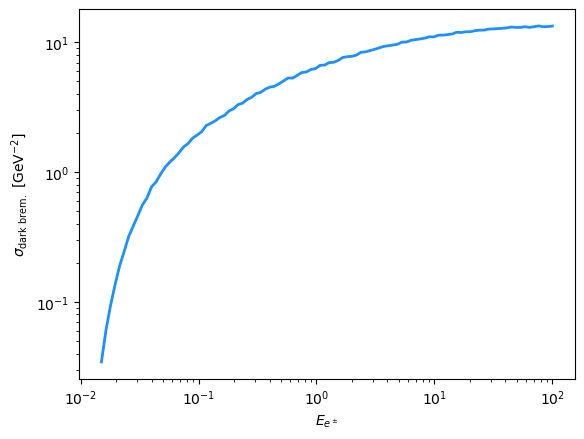

In [9]:
sX, sY = np.transpose(p0)
plt.plot(sX, sY, lw=2, color='dodgerblue')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}$")
plt.gca().set_ylabel(r"$\sigma_{\rm dark\ brem.}\ [\mathrm{GeV}^{-2}]$")

In [10]:
sX[70]

7.583420116615091

In [15]:
ntrials = []
xs = []
for k in tqdm(range(100000)):
    s0 = sGraphite.draw_dark_sample(4.55, 70, "ExactBrem", VB=True)
    xs.append([s0[0], s0[1]])
    ntrials.append(s0[-1])

100%|██████████| 100000/100000 [00:47<00:00, 2101.22it/s]


In [15]:
np.max(ntrials)

187.0

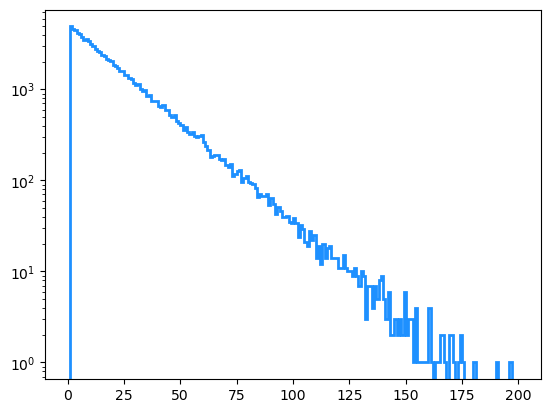

In [16]:
plt.hist(ntrials, bins=np.linspace(0, 200, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

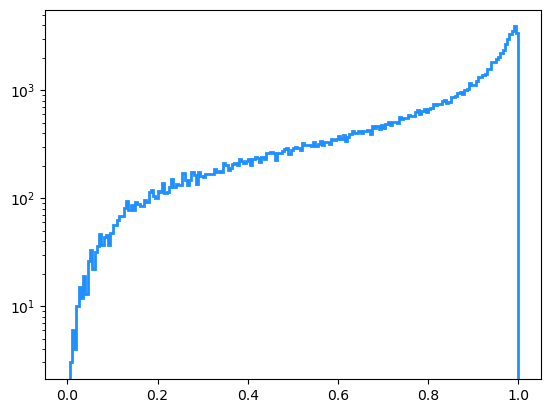

In [17]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

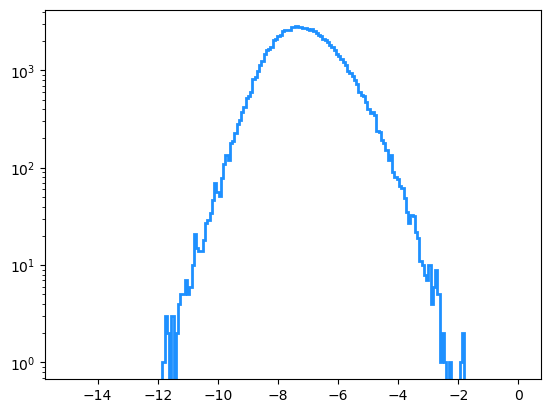

In [18]:
plt.hist(np.transpose(xs)[1], bins=np.linspace(-15,0, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [19]:
s0Positrons = np.array(s0SM)[np.where(np.array([s0.get_ids()[0] for s0 in s0SM]) == -11)[0]]

In [20]:
s0Positrons[0]

In [21]:
s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM))

 16%|█▌        | 165/1055 [00:00<00:01, 456.99it/s]/Users/kjkelly/Documents/miniforge3/envs/kjk/lib/python3.10/site-packages/PETITE/kinematics.py:98: RuntimeWarning: invalid value encountered in sqrt
  pF = np.sqrt(Ee**2 - me**2)
 25%|██▍       | 262/1055 [00:04<00:17, 46.11it/s] 

No Sample Found
Comp 0.01166057214905053 19


 28%|██▊       | 297/1055 [00:08<00:35, 21.66it/s]

No Sample Found
Comp 0.011409605244195365 19


 43%|████▎     | 450/1055 [00:13<00:16, 36.44it/s]

No Sample Found
Comp 0.011764787345478322 19


 51%|█████▏    | 543/1055 [00:17<00:16, 30.97it/s]

No Sample Found
Comp 0.011345224466099663 19


 64%|██████▍   | 680/1055 [00:21<00:10, 37.38it/s]

No Sample Found
Comp 0.01157940044642866 19


 76%|███████▋  | 805/1055 [00:26<00:07, 32.70it/s]

No Sample Found
Comp 0.011655473759963918 19


 84%|████████▎ | 881/1055 [00:30<00:06, 26.49it/s]

No Sample Found
Comp 0.01134793312408627 19
No Sample Found
Comp 0.011456860735987957 19


100%|██████████| 1055/1055 [00:35<00:00, 29.84it/s]


In [26]:
sGraphite.GetBSMWeights(22, 0.050)

0.2547230417705591

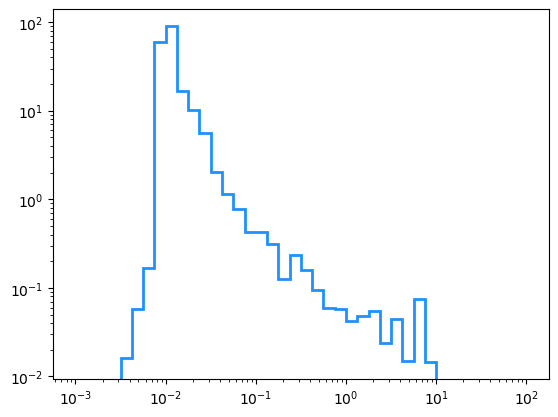

In [16]:
plt.hist([s0BSM[1][ii].get_p0()[0] for ii in range(len(s0BSM[1]))], weights=[s0BSM[1][ii].get_ids()[-1] for ii in range(len(s0BSM[1]))], bins=np.logspace(-3, 2, 41), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

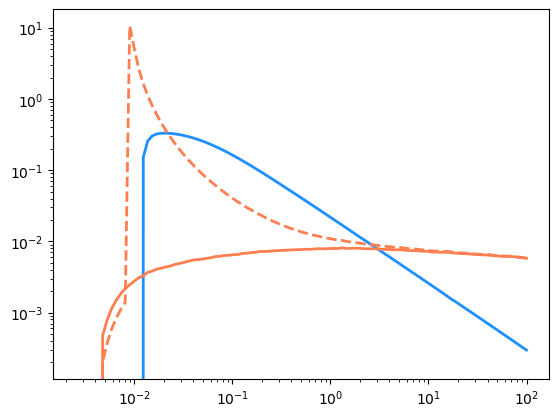

In [21]:
energyvec = np.logspace(-2.6, 2, 101)
plt.plot(energyvec, [sGraphite.GetBSMWeights(22, ee) for ee in energyvec], lw=2, color='dodgerblue')
plt.plot(energyvec, [sGraphite.GetBSMWeights(11, ee) for ee in energyvec], lw=2, color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights(-11, ee) for ee in energyvec], lw=2, ls='--', color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

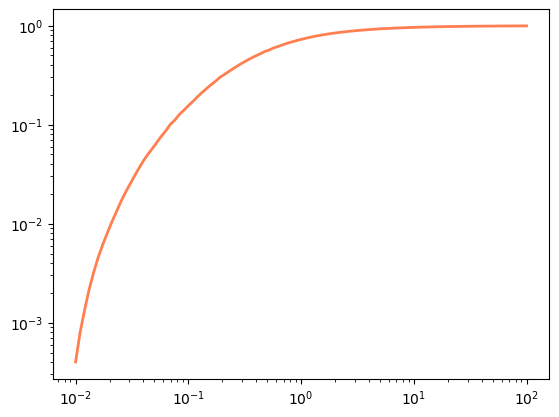

In [22]:
energyvec = np.logspace(-2., 2, 101)
plt.plot(energyvec, [sGraphite.GetPositronDarkBF(ee) for ee in energyvec], lw=2, color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [24]:
len(s0BSM[1])

1038

In [25]:
s = np.array(s0BSM[1])
s[np.where(np.array([p0.get_ids()[-2] for p0 in s0BSM[1]]) == 1)[0]]

array([<PETITE.particle.Particle object at 0x17fa004f0>,
       <PETITE.particle.Particle object at 0x17ff60c40>], dtype=object)

In [11]:
np.where(np.array([p0.get_ids()[0] == 22 for p0 in s0BSM[1]]))

(array([], dtype=int64),)

Now we create a list of energies to be used in the simulation.

In [ ]:
EVec = np.logspace(np.log10(0.0015), np.log10(100.), 100)
EVec[58], EVec[73]